# Model Selection

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.model_selection import KFold

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # Creating instance for standard scaler

# Reading the Data

In [7]:
data = pd.read_excel("Inconel_Compiled_Data_New_elems.xlsx")

In [8]:
df = data.copy()

# Splitting the Data into Train and Test Sets

In [9]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# Separating X and Y variables from Train Dataset

In [10]:
x_tr = train_set.drop(["Type", "Surface Roughness (µm)" , "MRR (mm3/min)"],
                      axis = 1).to_numpy()
y_tr = train_set[["Surface Roughness (µm)" , "MRR (mm3/min)"]].to_numpy()

# Standardazing X variables

In [11]:
x_tr_scaled = sc.fit_transform(x_tr)

# Creating List of Models to be applied

In [12]:
models = [LinearRegression() 
          , RandomForestRegressor(n_estimators=20, random_state=42)
          , MultiOutputRegressor(SVR(kernel='rbf'))
          , neighbors.KNeighborsRegressor(n_neighbors = 4)]

# Applying Models and Generate Initial Results

In [13]:
fr = []

for model in models:
    lr = model
    lr.fit(x_tr_scaled,y_tr)
    predict = lr.predict(x_tr_scaled)

    actual = y_tr

    # RMSE Calculation
    sr_p = [i[0] for i in predict]
    sr_a = [i[0] for i in actual]

    mrr_p = [i[1] for i in predict]
    mrr_a = [i[1] for i in actual]


    summation_sr = 0  #variable to store the summation of differences
    summation_mrr = 0

    n = len(sr_a) #finding total number of items in list

    for i in range (0,n):  #looping through each element of the list

        difference_sr = sr_a[i] - sr_p[i]  #finding the difference between observed and predicted value
        difference_mrr = mrr_a[i] - mrr_p[i]

        squared_difference_sr = difference_sr**2  #taking square of the differences
        squared_difference_mrr = difference_mrr**2

        summation_sr = summation_sr + squared_difference_sr  #taking a sum of all the differences
        summation_mrr = summation_mrr + squared_difference_mrr

        MSE_sr = summation_sr/n
        MSE_mrr = summation_mrr/n

        RMSE_sr = np.sqrt(MSE_sr)
        RMSE_mrr = np.sqrt(MSE_mrr)


    dictionary = {
        "Model" : model,
        "RMSE_SR" : RMSE_sr,
        "RMSE_MRR" : RMSE_mrr,
        }


    fr.append(dictionary)

results_initial = pd.DataFrame(fr)
a= results_initial.Model.unique()
b = ["Linear Regression", "Random Forest", "SVM", "KNN"]
results_initial.Model = results_initial.Model.map(dict(zip(a,b)))

results_initial.to_csv("Results_initial.csv", index = False)

results_initial

,Model,RMSE_SR,RMSE_MRR
0,Linear Regression,4.328221,155.169651
1,Random Forest,0.704498,18.708427
2,SVM,4.315385,227.923714
3,KNN,1.878115,41.668207


# Vizualizing Initial Results

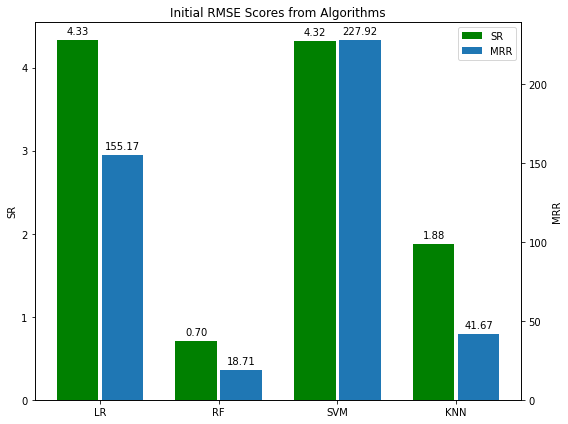

In [14]:
labels = ['LR', 'RF', 'SVM', 'KNN']

sr = results_initial["RMSE_SR"]
mrr = results_initial["RMSE_MRR"]

x = np.arange(len(labels))  # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize = (8,6))

ax2 = ax.twinx()
rects1 = ax.bar(x - width/1.85, sr, width, label='SR', color = "green")
rects2 = ax2.bar(x + width/1.85, mrr, width, label='MRR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SR')
ax.set_title('Initial RMSE Scores from Algorithms')
ax.set_xticks(x, labels)

ax.legend(handles=[rects1, rects2])
ax2.set_ylabel('MRR')

ax.bar_label(rects1, padding=4, fmt='%.2f')
ax2.bar_label(rects2, padding=4, fmt='%.2f')

fig.tight_layout()

plt.savefig("Initial RMSE Scores from Algorithms.jpg")

plt.show()

#### It appears that RF is the most suitable among all, but we will apply cross validation on all 4 algorithms to confirm

# Applying Cross Validation on all 4 Algorithms

In [15]:
kfold = KFold(n_splits = 10, random_state= 42, shuffle = True)

Note: A value of k=10 is very common in the field of applied machine learning, and is recommend if you are struggling to choose a value for your dataset.

Ref: https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20primarily%20used,the%20training%20of%20the%20model.

In [16]:
fr = []

for train_index, test_index in kfold.split(x_tr_scaled):
    
    x_train, x_test = x_tr_scaled[train_index], x_tr_scaled[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
    
    for model in models:

        lr = model
        lr.fit(x_train,y_train)
        predict = lr.predict(x_test)

        actual = y_test

        # RMSE Calculation
        sr_p = [i[0] for i in predict]
        sr_a = [i[0] for i in actual]

        mrr_p = [i[1] for i in predict]
        mrr_a = [i[1] for i in actual]


        summation_sr = 0  #variable to store the summation of differences
        summation_mrr = 0

        n = len(sr_a) #finding total number of items in list

        for i in range (0,n):  #looping through each element of the list

            difference_sr = sr_a[i] - sr_p[i]  #finding the difference between observed and predicted value
            difference_mrr = mrr_a[i] - mrr_p[i]

            squared_difference_sr = difference_sr**2  #taking square of the differences 
            squared_difference_mrr = difference_mrr**2

            summation_sr = summation_sr + squared_difference_sr  #taking a sum of all the differences
            summation_mrr = summation_mrr + squared_difference_mrr

            MSE_sr = summation_sr/n
            MSE_mrr = summation_mrr/n

            RMSE_sr = np.sqrt(MSE_sr)
            RMSE_mrr = np.sqrt(MSE_mrr)
        

        dictionary = {
            "Model" : model,
            "RMSE_SR" : RMSE_sr,
            "RMSE_MRR" : RMSE_mrr,
            }


        fr.append(dictionary)



cross_results = pd.DataFrame(fr)
a= cross_results.Model.unique()
b = ["Linear Regression", "Random Forest", "SVM", "KNN"]
cross_results.Model = cross_results.Model.map(dict(zip(a,b)))
cross_results.sort_values(["Model"], inplace =True)
cross_results.to_csv("Cross_Validation_Results_on_All_Four.csv", index = False)
cross_results

,Model,RMSE_SR,RMSE_MRR
19,KNN,2.204703,62.346608
35,KNN,1.186280,63.154831
31,KNN,2.252887,55.096145
27,KNN,3.919831,39.932698
23,KNN,1.706416,62.261271
15,KNN,2.289610,61.052642
11,KNN,1.239331,20.629819
39,KNN,3.557879,9.149484
3,KNN,2.475678,34.517297
7,KNN,1.560162,118.725964


# Vizualizing Cross Validation Results for All 4 Algorithms

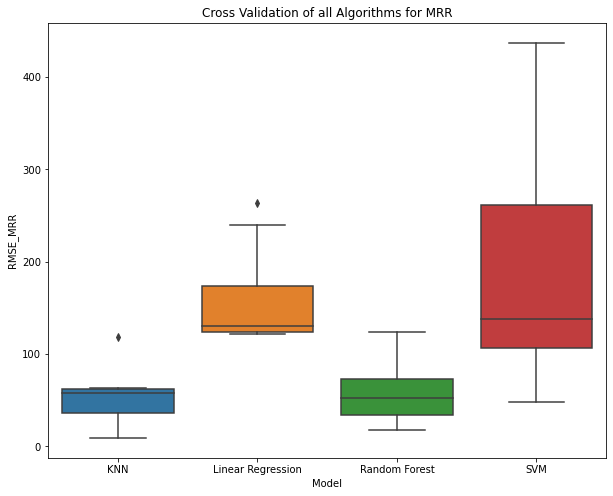

In [17]:
plt.figure(figsize = (10,8))
sns.boxplot(data = cross_results, y= "RMSE_MRR", x ="Model").set(
    title = "Cross Validation of all Algorithms for MRR");
plt.savefig("Cross_Val_All_Algo_MRR_boxplot.jpg")

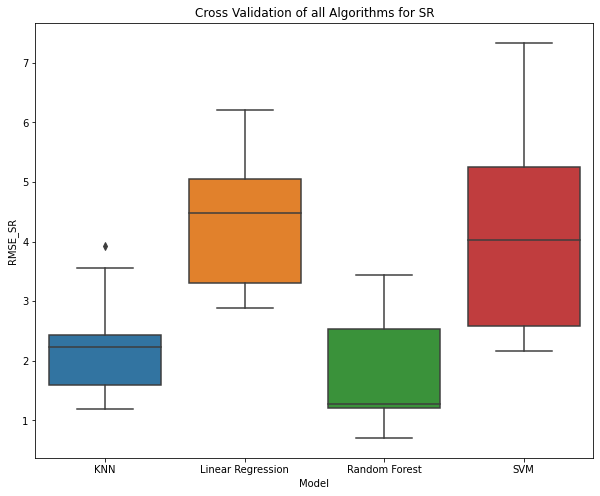

In [18]:
plt.figure(figsize = (10,8))
sns.boxplot(data = cross_results, y= "RMSE_SR", x ="Model").set(
    title = "Cross Validation of all Algorithms for SR");
plt.savefig("Cross_Val_All_Algo_SR_boxplot.jpg")

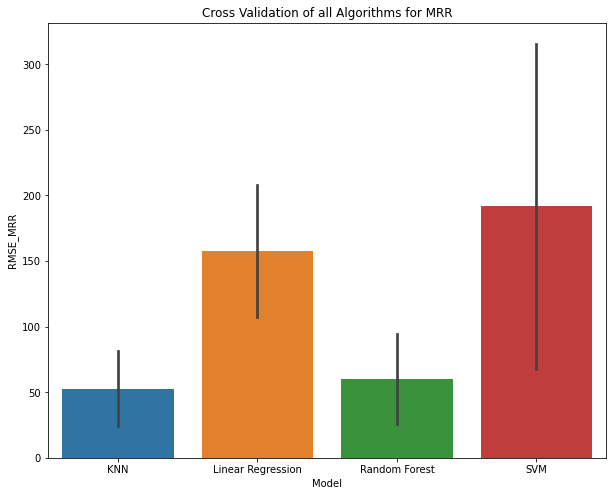

In [19]:
plt.figure(figsize = (10,8))
sns.barplot(x = "Model", y = "RMSE_MRR",data = cross_results, ci = "sd").set(
    title = "Cross Validation of all Algorithms for MRR")
plt.savefig("Cross_Val_All_Algo_MRR_barplot.jpg")

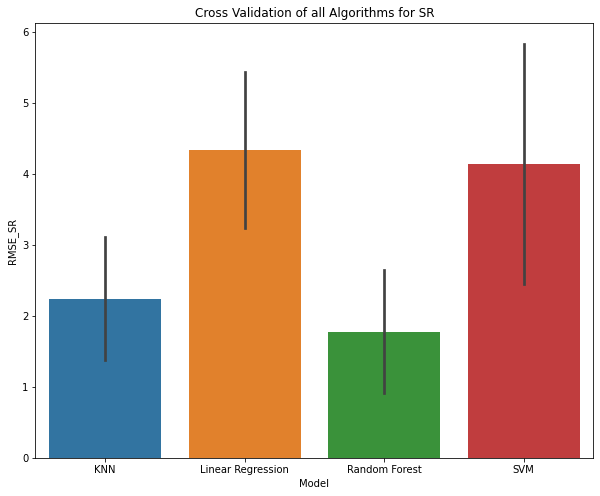

In [20]:
plt.figure(figsize = (10,8))
sns.barplot(x = "Model", y = "RMSE_SR",data = cross_results, ci = "sd").set(
    title = "Cross Validation of all Algorithms for SR")
plt.savefig("Cross_Val_All_Algo_SR_barplot.jpg")

In [21]:
r_sr = cross_results.groupby("Model")["RMSE_SR"].agg(["mean", "std"])
r_sr.rename(columns = {'mean' : "RMSE_SR_Mean", "std": "RMSE_SR_Std"}, inplace= True)
r_mrr = cross_results.groupby("Model")["RMSE_MRR"].agg(["mean", "std"])
r_mrr.rename(columns = {'mean' : "RMSE_MRR_Mean", "std": "RMSE_MRR_Std"}, inplace= True)
comp = pd.concat([r_sr, r_mrr], axis =1)
comp.to_csv("Cross_Validation_Mean_ALl_Algo.csv")
comp

,RMSE_SR_Mean,RMSE_SR_Std,RMSE_MRR_Mean,RMSE_MRR_Std
Model,,,,
KNN,2.239278,0.911446,52.686676,30.087782
Linear Regression,4.332914,1.153544,157.730534,53.251585
Random Forest,1.777711,0.916008,59.991218,36.062783
SVM,4.139240,1.784803,191.911987,130.574625


#### Random Forest performs best for SR, whereas KNN performs best for MRR

#### First we will find parameters for Random Forest, then for KNN

# Parameter Tunning for RF

In [22]:
fr = []

estimators = range(1,21)

for est in estimators:

    lr = RandomForestRegressor(n_estimators=est, random_state=42)
    lr.fit(x_tr_scaled,y_tr)
    
    predict = lr.predict(x_tr_scaled)

    actual = y_tr

    # RMSE Calculation
    sr_p = [i[0] for i in predict]
    sr_a = [i[0] for i in actual]

    mrr_p = [i[1] for i in predict]
    mrr_a = [i[1] for i in actual]


    summation_sr = 0  #variable to store the summation of differences
    summation_mrr = 0

    n = len(sr_a) #finding total number of items in list

    for i in range (0,n):  #looping through each element of the list

        difference_sr = sr_a[i] - sr_p[i]  #finding the difference between observed and predicted value
        difference_mrr = mrr_a[i] - mrr_p[i]

        squared_difference_sr = difference_sr**2  #taking square of the differences
        squared_difference_mrr = difference_mrr**2

        summation_sr = summation_sr + squared_difference_sr  #taking a sum of all the differences
        summation_mrr = summation_mrr + squared_difference_mrr

    MSE_sr = summation_sr/n
    MSE_mrr = summation_mrr/n

    RMSE_sr = np.sqrt(MSE_sr)
    RMSE_mrr = np.sqrt(MSE_mrr)


    dictionary = {
        "Estimators" : est,
        "RMSE_SR" : RMSE_sr,
        "RMSE_MRR" : RMSE_mrr            
        }


    fr.append(dictionary)

rf = pd.DataFrame(fr)
rf.to_csv("RF_Parameter_Tuning.csv", index = False)

rf

,Estimators,RMSE_SR,RMSE_MRR
0,1,1.744588,33.494527
1,2,1.304265,25.205571
2,3,0.924497,25.951893
3,4,0.943693,27.219166
4,5,0.830706,24.667806
5,6,0.774644,23.090775
6,7,0.763482,24.197440
7,8,0.739802,23.658888
8,9,0.767500,23.316622
9,10,0.783856,21.910707


# Vizualizing Number of Trees vs RMSE of SR and MRR

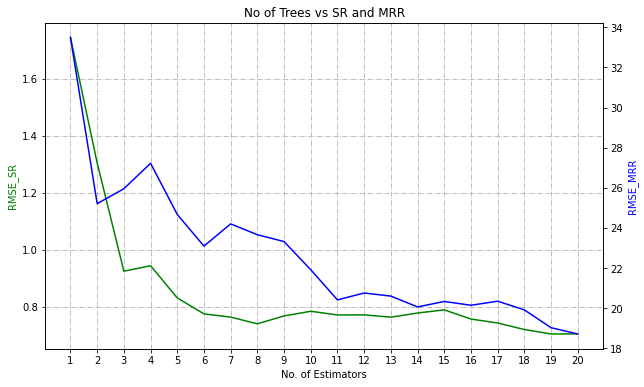

In [23]:
fig, ax1 = plt.subplots(figsize = (10,6))

ax2 = ax1.twinx()
ax1.plot(estimators, rf["RMSE_SR"], 'g-')
ax2.plot(estimators, rf["RMSE_MRR"], 'b-')

ax1.set_xlabel('No. of Estimators')
ax1.set_ylabel('RMSE_SR', color='g')
ax2.set_ylabel('RMSE_MRR', color='b')

ax1.grid(True, linestyle='-.')

tickpos = list(estimators)

plt.xticks(tickpos,tickpos)
plt.title("No of Trees vs SR and MRR")

plt.savefig("No of Trees vs SR and MRR.jpg")
plt.show()

### 20 number of trees yield best results, So we will cross validate Random Forest with 20 number of Trees

# Cross Validation on RF based by keeping no. of trees = 20

In [24]:
fr = []

k = 1

for train_index, test_index in kfold.split(x_tr_scaled):
    
    x_train, x_test = x_tr_scaled[train_index], x_tr_scaled[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]

    lr = RandomForestRegressor(n_estimators=20, random_state=42)
    lr.fit(x_train,y_train)
    predict = lr.predict(x_test)

    actual = y_test

    # RMSE Calculation
    sr_p = [i[0] for i in predict]
    sr_a = [i[0] for i in actual]

    mrr_p = [i[1] for i in predict]
    mrr_a = [i[1] for i in actual]


    summation_sr = 0  #variable to store the summation of differences
    summation_mrr = 0

    n = len(sr_a) #finding total number of items in list

    for i in range (0,n):  #looping through each element of the list

        difference_sr = sr_a[i] - sr_p[i]  #finding the difference between observed and predicted value
        difference_mrr = mrr_a[i] - mrr_p[i]

        squared_difference_sr = difference_sr**2  #taking square of the differences
        squared_difference_mrr = difference_mrr**2

        summation_sr = summation_sr + squared_difference_sr  #taking a sum of all the differences
        summation_mrr = summation_mrr + squared_difference_mrr

        MSE_sr = summation_sr/n
        MSE_mrr = summation_mrr/n

        RMSE_sr = np.sqrt(MSE_sr)
        RMSE_mrr = np.sqrt(MSE_mrr)


    dictionary = {
        "Model" : "RF",
        "RMSE_SR" : RMSE_sr,
        "RMSE_MRR" : RMSE_mrr,
        "Fold No." : k
        }


    fr.append(dictionary)

    k+=1

rf_20 = pd.DataFrame(fr)
rf_20_sr = rf_20.groupby("Model")["RMSE_SR"].agg(["mean", "std"])
rf_20_sr.rename(columns = {'mean' : "RMSE_SR_Mean", "std": "RMSE_SR_Std"}, inplace= True)

rf_20_mrr = rf_20.groupby("Model")["RMSE_MRR"].agg(["mean", "std"])
rf_20_mrr.rename(columns = {'mean' : "RMSE_SR_Mean", "std": "RMSE_SR_Std"}, inplace= True)

rf_20_cross_val = pd.concat([rf_20_sr, rf_20_mrr], axis=1)
rf_20_cross_val.to_csv("RF_20_Cross_Val_Results.csv")
rf_20_cross_val

,RMSE_SR_Mean,RMSE_SR_Std,RMSE_SR_Mean,RMSE_SR_Std
Model,,,,
RF,1.777711,0.916008,59.991218,36.062783


# Parameter Tunning for KNN

In [25]:
fr = []

estimators = range(1,21)

for est in estimators:

    lr = neighbors.KNeighborsRegressor(n_neighbors = est)
    lr.fit(x_tr_scaled,y_tr)
    
    predict = lr.predict(x_tr_scaled)

    actual = y_tr

    # RMSE Calculation
    sr_p = [i[0] for i in predict]
    sr_a = [i[0] for i in actual]

    mrr_p = [i[1] for i in predict]
    mrr_a = [i[1] for i in actual]


    summation_sr = 0  #variable to store the summation of differences
    summation_mrr = 0

    n = len(sr_a) #finding total number of items in list

    for i in range (0,n):  #looping through each element of the list

        difference_sr = sr_a[i] - sr_p[i]  #finding the difference between observed and predicted value
        difference_mrr = mrr_a[i] - mrr_p[i]

        squared_difference_sr = difference_sr**2  #taking square of the differences
        squared_difference_mrr = difference_mrr**2

        summation_sr = summation_sr + squared_difference_sr  #taking a sum of all the differences
        summation_mrr = summation_mrr + squared_difference_mrr

    MSE_sr = summation_sr/n
    MSE_mrr = summation_mrr/n

    RMSE_sr = np.sqrt(MSE_sr)
    RMSE_mrr = np.sqrt(MSE_mrr)


    dictionary = {
        "Estimators" : est,
        "RMSE_SR" : RMSE_sr,
        "RMSE_MRR" : RMSE_mrr            
        }


    fr.append(dictionary)
    
knn = pd.DataFrame(fr)
knn.to_csv("KNN_Parameter_Tuning.csv", index = False)

knn

,Estimators,RMSE_SR,RMSE_MRR
0,1,0.205198,0.150360
1,2,1.199465,30.546262
2,3,1.840616,38.401000
3,4,1.878115,41.668207
4,5,1.912881,47.443957
5,6,2.071054,49.360603
6,7,2.149581,59.081334
7,8,2.256224,71.634935
8,9,2.327642,79.314669
9,10,2.353073,86.369789


# Vizualizing Number of Neighbors vs RMSE of SR and MRR

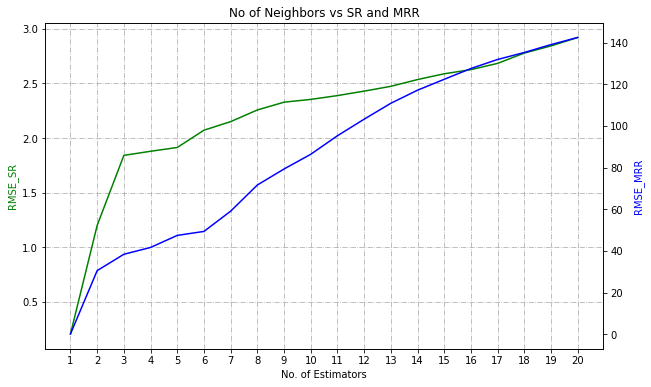

In [26]:
fig, ax1 = plt.subplots(figsize = (10,6))

ax2 = ax1.twinx()
ax1.plot(estimators, knn["RMSE_SR"], 'g-')
ax2.plot(estimators, knn["RMSE_MRR"], 'b-')

ax1.set_xlabel('No. of Estimators')
ax1.set_ylabel('RMSE_SR', color='g')
ax2.set_ylabel('RMSE_MRR', color='b')

ax1.grid(True, linestyle='-.')

tickpos = list(estimators)

plt.xticks(tickpos,tickpos)
plt.title("No of Neighbors vs SR and MRR")

plt.savefig("No of Neighbors vs SR and MRR.jpg")
plt.show()

Note: We can not go further with KNN because as the no. of neigbors increases, the RMSE scores also increase, which we 
have to avoid.

Why we cant use n=1 in KNN

https://stats.stackexchange.com/questions/440064/is-k-1-is-good-for-knn-when-error-is-min-accuracy-is-max-and-even-auroc-is-m#:~:text=The%20error%20rate%20at%20K,and%20plot%20the%20validation%20error.

# Finally we are selecting RF Model, with no. of trees = 20. With this Model we will test our dataset

# Separating x and y variables from the Test dataset

In [27]:
x_ts = test_set.drop(["Type", "Surface Roughness (µm)" , "MRR (mm3/min)"],
                     axis = 1).to_numpy()
y_ts = test_set[["Surface Roughness (µm)" , "MRR (mm3/min)"]].to_numpy()

# Standardazing X variables

In [28]:
x_ts_scaled = sc.transform(x_ts)

# Running Random Forest with 20 number of trees and taking predictions on Test dataset

In [29]:
fr_20 = []

# Model Training and Prediction
lr = RandomForestRegressor(n_estimators=20, random_state=42)
lr.fit(x_tr_scaled,y_tr)

predict = lr.predict(x_ts_scaled)

actual = y_ts

# RMSE Calculation
sr_p_20 = [i[0] for i in predict]
sr_a_20 = [i[0] for i in actual]

mrr_p_20 = [i[1] for i in predict]
mrr_a_20 = [i[1] for i in actual]


summation_sr_20 = 0  #variable to store the summation of differences
summation_mrr_20 = 0

n = len(sr_a_20) #finding total number of items in list

for i in range (0,n):  #looping through each element of the list

    difference_sr_20 = sr_a_20[i] - sr_p_20[i]  #finding the difference between observed and predicted value
    difference_mrr_20 = mrr_a_20[i] - mrr_p_20[i]

    squared_difference_sr_20 = difference_sr_20**2  #taking square of the differences
    squared_difference_mrr_20 = difference_mrr_20**2

    summation_sr_20 = summation_sr_20 + squared_difference_sr_20  #taking a sum of all the differences
    summation_mrr_20 = summation_mrr_20 + squared_difference_mrr_20

MSE_sr_20 = summation_sr_20/n
MSE_mrr_20 = summation_mrr_20/n

RMSE_sr_20 = np.sqrt(MSE_sr_20)
RMSE_mrr_20 = np.sqrt(MSE_mrr_20)


dictionary = {
    "Estimators" : 20,
    "RMSE_SR" : RMSE_sr_20,
    "RMSE_MRR" : RMSE_mrr_20            
    }


fr_20.append(dictionary)

final_rf_20 = pd.DataFrame(fr_20)

final_rf_20.to_csv("Final_RF_20_Results.csv", index =False)

final_rf_20

,Estimators,RMSE_SR,RMSE_MRR
0,20,1.570611,73.938661


# Calculating Confidence Intervals

Ref from Book: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (2019), Page 110

In [30]:
confidence = 0.95

In [31]:
squared_errors = (np.array(mrr_a_20) - np.array(mrr_p_20)) ** 2
se_mrr = np.sqrt(stats.t.interval(confidence, 
                                  len(squared_errors) - 1, 
                                  loc=squared_errors.mean(), 
                                  scale = stats.sem(squared_errors)/2))

In [32]:
print("95% Confidence Interval for RMSE MRR is:", se_mrr[0], "to", se_mrr[1])

95% Confidence Interval for RMSE MRR is: 51.91782574832816 to 90.76557942303033


In [33]:
squared_errors = (np.array(sr_a_20) - np.array(sr_p_20)) ** 2
se_sr = np.sqrt(stats.t.interval(confidence, 
                                 len(squared_errors) - 1, 
                                 loc=squared_errors.mean(),
                                 scale = stats.sem(squared_errors) ))

In [34]:
print("95% Confidence Interval for RMSE SR is:", se_sr[0], "to", se_sr[1])

95% Confidence Interval for RMSE SR is: 0.5999948932051761 to 2.13860754088344
